# Tabular data classification: Classify raisin

Author: Mark Yean

Affliation: HT Consulting (Asia) Sdn. Bhd., Kelana Jaya, Malaysia

Published: May 2024

##### Copyright Kaggle

---
We have go through image classification with fashion mnist dataset. Now let's see classification using _**tabular**_ data.

### About the dataset

This [dataset](https://www.kaggle.com/datasets/muratkokludataset/raisin-dataset/data) which contains 7 morphological feature extracted from 900 pieces raisin grains from an equal number of both varieties (Kecimen and Besni).

Attribute Information:

Area: Gives the number of pixels within the boundaries of the raisin.
- Perimeter: It measures the environment by calculating the distance between the boundaries of the raisin and the pixels around it.
- MajorAxisLength: Gives the length of the main axis, which is the longest line that can be drawn on the raisin.
- MinorAxisLength: Gives the length of the small axis, which is the shortest line that can be drawn on the raisin.
- Eccentricity: It gives a measure of the eccentricity of the ellipse, which has the same moments as raisins.
- ConvexArea: Gives the number of pixels of the smallest convex shell of the region formed by the raisin.
- Extent: Gives the ratio of the region formed by the raisin to the total pixels in the bounding box.
- Class: Kecimen and Besni raisin.

For an ellipse, eccentricity (denoted by the letter "e") is a dimensionless parameter that quantifies how far the shape deviates from being a perfect circle. The eccentricity value ranges from 0 to 1.

- When eccentricity (e) is 0, the ellipse is a perfect circle.
- When eccentricity is close to 1 (approaching 1), the ellipse becomes more elongated and "flatter," looking like a thin oval shape.
- When eccentricity is exactly 1, the shape is a parabola.
- When eccentricity is greater than 1, the shape becomes a hyperbola.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# ML models
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn import svm
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from xgboost import XGBClassifier

In [2]:
# load data
df_pth = "kismis/Raisin_Dataset.xlsx"
df = pd.read_excel(df_pth)
df.head()

Area  MajorAxisLength  MinorAxisLength  Eccentricity  ConvexArea  \
0  87524       442.246011       253.291155      0.819738       90546   
1  75166       406.690687       243.032436      0.801805       78789   
2  90856       442.267048       266.328318      0.798354       93717   
3  45928       286.540559       208.760042      0.684989       47336   
4  79408       352.190770       290.827533      0.564011       81463   

     Extent  Perimeter    Class  
0  0.758651   1184.040  Kecimen  
1  0.684130   1121.786  Kecimen  
2  0.637613   1208.575  Kecimen  
3  0.699599    844.162  Kecimen  
4  0.792772   1073.251  Kecimen

Converting class values to 0 and 1 and making sure every column is numerical.

## EDA

In [3]:
print(f"Dataset have {df.shape[0]} rows and {df.shape[1]} columns" )

Dataset have 900 rows and 8 columns


In [4]:
df['Class'].unique()

array(['Kecimen', 'Besni'], dtype=object)

In [5]:
df['Class'].value_counts()

Class
Kecimen    450
Besni      450
Name: count, dtype: int64

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 900 entries, 0 to 899
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Area             900 non-null    int64  
 1   MajorAxisLength  900 non-null    float64
 2   MinorAxisLength  900 non-null    float64
 3   Eccentricity     900 non-null    float64
 4   ConvexArea       900 non-null    int64  
 5   Extent           900 non-null    float64
 6   Perimeter        900 non-null    float64
 7   Class            900 non-null    object 
dtypes: float64(5), int64(2), object(1)
memory usage: 56.4+ KB


- count the number of **_NaN_** values in a specific column in a Pandas DataFrame

In [7]:
df.isnull().sum()

Area               0
MajorAxisLength    0
MinorAxisLength    0
Eccentricity       0
ConvexArea         0
Extent             0
Perimeter          0
Class              0
dtype: int64

We have check that there are _**no null**_ value or _**nan value**_ in the dataframe. Will proceed with checking outliers.

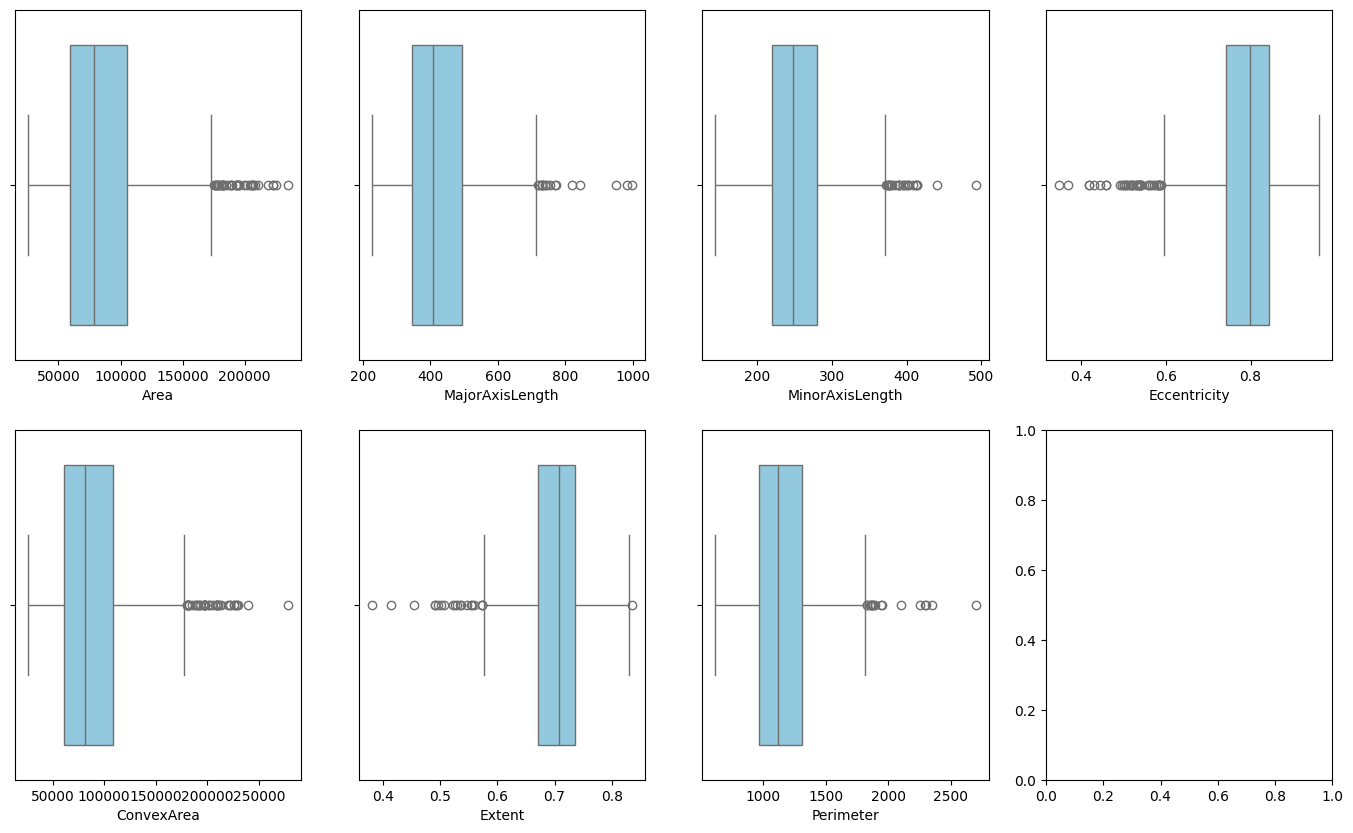

In [8]:
box_df = df.copy()
rows,cols =(2,4)
fig, axes = plt.subplots(rows, cols, figsize=(17, 5*rows))
axes = axes.flatten()
for i,f in enumerate(box_df.select_dtypes(include=[np.number]).columns):
    sns.boxplot(x=box_df[f], ax=axes[i], color='skyblue')

Checking via Feature Distributions by Class

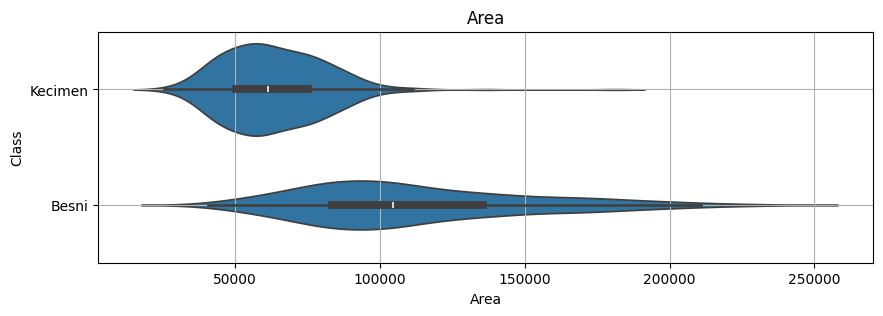

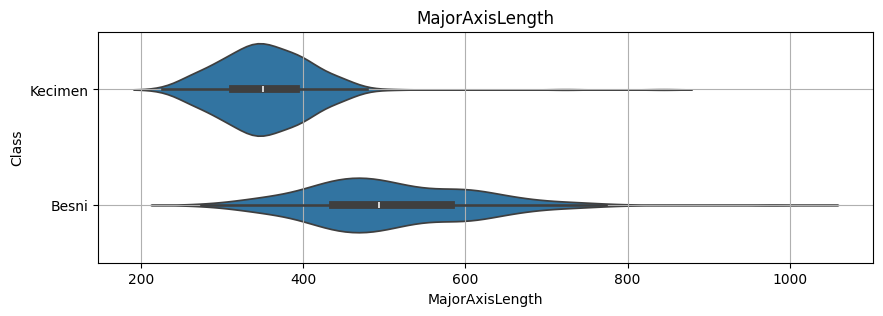

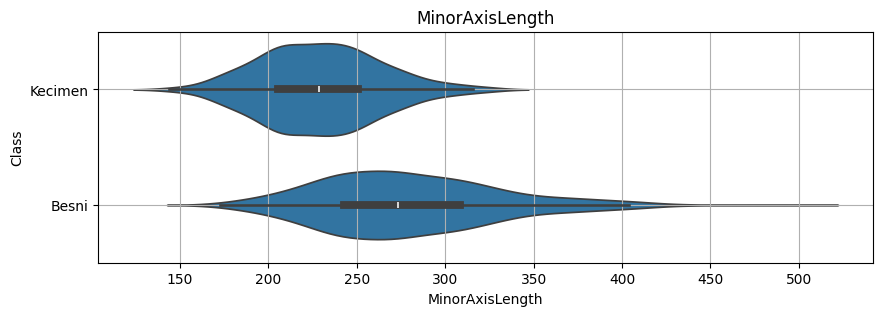

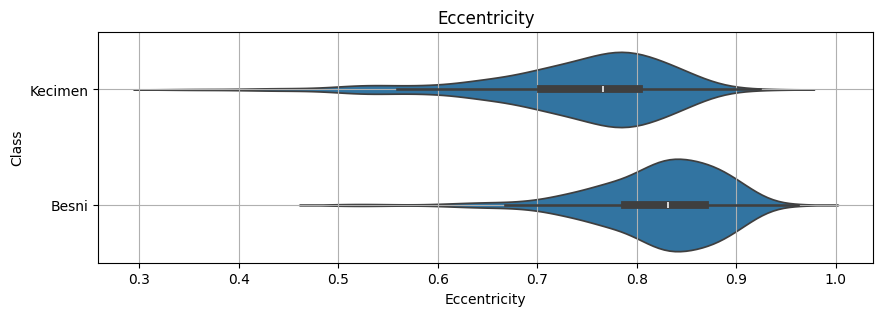

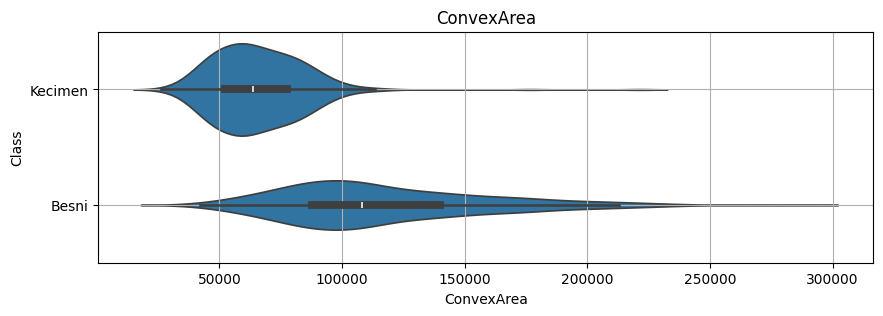

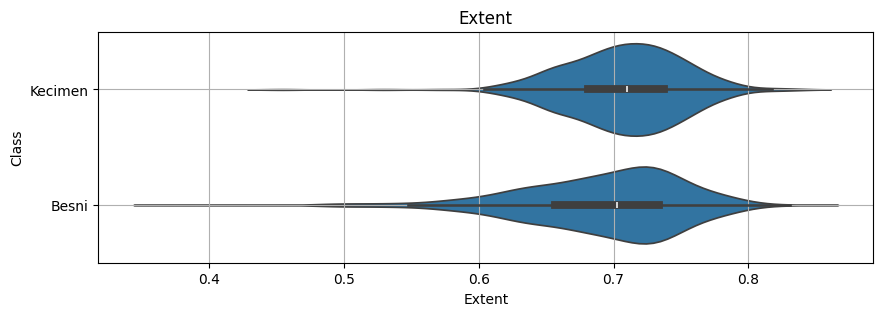

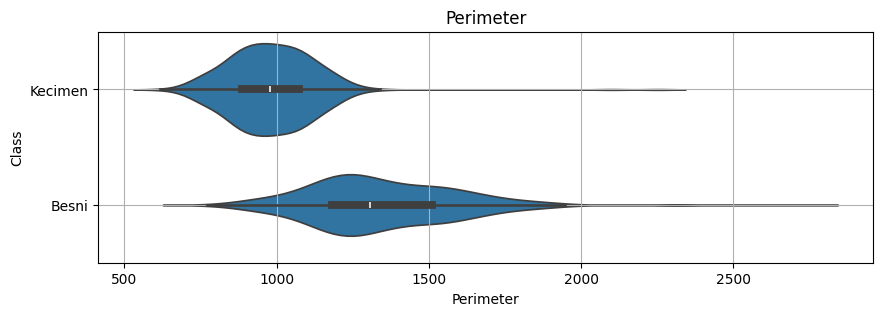

In [9]:
# basic stats for numerical features
features_num = ['Area', 'MajorAxisLength', 'MinorAxisLength', 
                'Eccentricity', 'ConvexArea', 'Extent', 'Perimeter']

# plot distributions split by class for each feature
for f in features_num:
    plt.figure(figsize=(10,3))
    sns.violinplot(data=df, y='Class', x=f)
    plt.grid()
    plt.title(f)
    plt.show()

Now let's see whether there's correlation between all 7 features using correlation heatmap.

C:\Users\User\AppData\Local\Temp\ipykernel_39448\1341104629.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['Class'] = df['Class'].replace(['Kecimen', 'Besni'], [0,1])


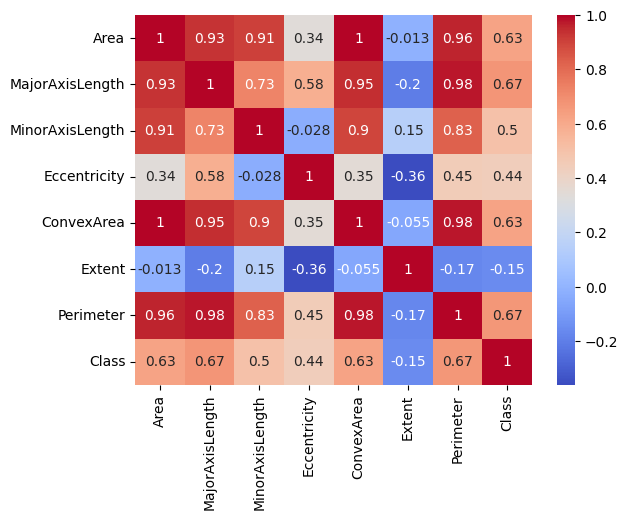

In [10]:
df['Class'] = df['Class'].replace(['Kecimen', 'Besni'], [0,1])
correlation_matrix = df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.show()

From above, we can say majority of feature are highly correlation since value are near to 1. The percentage is still high that's why I am not discarding all attribute it.

## Modelling

In [11]:
X = df.iloc[:, :-1].values
y = df.iloc[:, -1].values

In [12]:
# label encode
le = LabelEncoder()
y = le.fit_transform(y)

#split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.15, random_state = 0)

# scaling
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

## XGBoost

In [13]:
classifier = XGBClassifier()
classifier.fit(X_train, y_train)

y_pred = classifier.predict(X_test)

In [14]:
cm = confusion_matrix(y_test, y_pred)
print(cm)
print("Accuracy of model = %2f%%" % (accuracy_score(y_test, y_pred )*100))

[[54  4]
 [ 9 68]]
Accuracy of model = 90.370370%


In [15]:
cr = classification_report(y_test, y_pred)
print(cr)

              precision    recall  f1-score   support

           0       0.86      0.93      0.89        58
           1       0.94      0.88      0.91        77

    accuracy                           0.90       135
   macro avg       0.90      0.91      0.90       135
weighted avg       0.91      0.90      0.90       135



## MLP

In [16]:
mlp = MLPClassifier()  #default
# Train the classifier with the traning data
mlp.fit(X_train,y_train)
y_pred = mlp.predict(X_test)
print("Accuracy of model = %2f%%" % (accuracy_score(y_test, y_pred )*100))

Accuracy of model = 91.111111%


C:\Users\User\Downloads\MYJRP_ENV\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [17]:
cm = confusion_matrix(y_test, y_pred)
print(cm)

[[55  3]
 [ 9 68]]


In [18]:
cr = classification_report(y_test, y_pred)
print(cr)

              precision    recall  f1-score   support

           0       0.86      0.95      0.90        58
           1       0.96      0.88      0.92        77

    accuracy                           0.91       135
   macro avg       0.91      0.92      0.91       135
weighted avg       0.92      0.91      0.91       135



## SVM

In [19]:
svm_classifier = svm.SVC(gamma=0.001)  # as is in https://scikit-learn.org/stable/auto_examples/classification/plot_digits_classification.html
#fit to the trainin data
svm_classifier.fit(X_train,y_train)
y_pred = svm_classifier.predict(X_test)

print("Accuracy of model = %2f%%" % (accuracy_score(y_test, y_pred )*100))

Accuracy of model = 87.407407%


In [20]:
cm = confusion_matrix(y_test, y_pred)
print(cm)

[[55  3]
 [14 63]]


In [21]:
cr = classification_report(y_test, y_pred)
print(cr)

              precision    recall  f1-score   support

           0       0.80      0.95      0.87        58
           1       0.95      0.82      0.88        77

    accuracy                           0.87       135
   macro avg       0.88      0.88      0.87       135
weighted avg       0.89      0.87      0.87       135



| Algorithm    | Test Accuracy |
| -------- | ------- |
| XGBoost  | 90.37037037037037%    |
| MLP  | 90.370370%  |
| SVM    | 87.407407%%   |

From all evaluation from testing sample, XGBoost and MLP seems to give finest result.

Note: This is one of many approach performing EDA and ML modeling. 